In [1]:
from keras.datasets import mnist
import numpy as np
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [2]:
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train - 127.5)/127.5
x_test_shaped = (x_test - 127.5)/127.5

In [5]:
print('原本的y_train shape:', y_train.shape)
y_train

原本的y_train shape: (60000,)


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
# 這裡reshape比較特別的參數是-1
# nparray的reshape容許你填入一個-1
# -1是指會自動幫你算出-1該等於多少
# ex (2, 3) reshape (-1, 1) 相當於reshape成(6, 1)
y_train = y_train.reshape(-1, 1)
print('後來的y_train shape:', y_train.shape)
y_train

後來的y_train shape: (60000, 1)


array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=uint8)

In [2]:
img_shape = (28, 28)
random_dim = 100

In [4]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization

# 這裡跟我們GAN的創作家一模一樣
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.add(Reshape(img_shape))
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [5]:
# 這裡必需使用Model來做比較複雜的模型
noise = Input(shape=(random_dim,))
# 我們的標籤輸入 輸入只有一個維度 (1, )的,是為了讓小括號被當成tuple
# 否則會被當成普通的()
label = Input(shape=(1,), dtype='int32')
# 使用Embedding得到100向量
# input_dim = 10 -> 0~9
# output_dim = 100 -> 100維度的向量
# 接著使用Flatten把(1, 100)轉化成為(100)
label_embedding = Flatten()(Embedding(input_dim = 10, output_dim = random_dim)(label))
# 把靈感和標籤乘起來
model_input = multiply([noise, label_embedding])
# 經過我們上面的Generator做出圖片
img = generator(model_input)
# 完整的generator
# inputs = [noise, label] -> [靈感, 標籤]
# outputs = img -> 創作圖片
cgenerator = Model([noise, label], img)
cgenerator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_2

In [6]:
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=784,
                        activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total para

In [10]:
img = Input(shape=img_shape)
# 得到標籤的 784 維度表示
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(input_dim=10, output_dim=784)(label))
flat_img = Flatten()(img)
model_input = multiply([flat_img, label_embedding])
validity = discriminator(model_input)
cdiscriminator = Model([img, label], validity)
cdiscriminator.compile(loss='binary_crossentropy', optimizer="adam")
cdiscriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 28, 28)       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 784)       7840        input_12[0][0]                   
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 784)          0           input_11[0][0]                   
__________________________________________________________________________________________________
flatten_9 

In [14]:
# 記得在組合網路的時候必須讓鑑賞家保持不動!
cdiscriminator.trainable = False
cgan_input = Input(shape=(random_dim,))
cgan_label = Input(shape=(1, ))
x = cgenerator([cgan_input, cgan_label])
cgan_output = cdiscriminator([x, cgan_label])
cgan = Model(inputs=[cgan_input, cgan_label], outputs=cgan_output)
cgan.compile(loss='binary_crossentropy', optimizer="adam")
cgan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28)       563704      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            574113      model_1[1][0]                    
          

In [19]:
batch_size = 200
epoch_count = 100

for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]
        # 不一樣的點在這裡!我們有把訓練資料的標籤拿出來
        labels = y_train[idx]
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 跟普通GAN不一樣, 帶入了標籤部分
        gen_imgs = cgenerator.predict([noise, labels])

        # 步驟1:讓鑑賞家鑑賞對的image
        d_loss_real = cdiscriminator.train_on_batch([imgs, labels], valid)
        # 步驟2:讓鑑賞家鑑賞錯的image
        d_loss_fake = cdiscriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3:訓練創作家的創作能力
        g_loss = cgan.train_on_batch([noise, labels], valid)

    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)



--------------- epoch 10 ---------------
Discriminator loss: 0.5831745862960815
Generator loss: 1.2670963
--------------- epoch 20 ---------------
Discriminator loss: 0.5439196825027466
Generator loss: 1.1932579
--------------- epoch 30 ---------------
Discriminator loss: 0.5193800926208496
Generator loss: 1.1459067
--------------- epoch 40 ---------------
Discriminator loss: 0.588961124420166
Generator loss: 1.0838479
--------------- epoch 50 ---------------
Discriminator loss: 0.5306670665740967
Generator loss: 1.1740686
--------------- epoch 60 ---------------
Discriminator loss: 0.5842047929763794
Generator loss: 1.2247632
--------------- epoch 70 ---------------
Discriminator loss: 0.5230212807655334
Generator loss: 1.2086267
--------------- epoch 80 ---------------
Discriminator loss: 0.5432819128036499
Generator loss: 1.2568197
--------------- epoch 90 ---------------
Discriminator loss: 0.5319997072219849
Generator loss: 1.2006314
--------------- epoch 100 ---------------
Discr

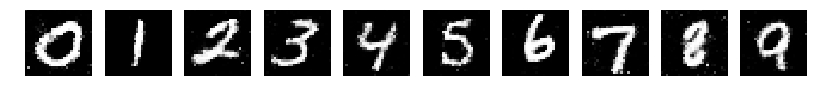

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
noise = np.random.normal(0, 1, (10, random_dim))
sampled_labels = np.arange(0, 10).reshape(-1, 1)

gen_imgs = cgenerator.predict([noise, sampled_labels])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(10, 28, 28)
plt.figure(figsize = (14, 14))
# range(0, 10)產生出十種不同label(0 - 9) 針對性的產生我們要的數字
for i in range(0, 10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(gen_imgs[i], cmap='gray')